# Assignment 3 - Variational Autoencoders (VAEs)

Nathan Willemsen

DS552 - Generative AI | Prof. Narahara Chari Dingari, Ph.D.

January 31, 2025

---

### Assignment Overview
This assignment compares the performance of Naive Bayes (a generative model) and Logistic Regression (a discriminative model) using the Palmer Penguins dataset. We focus on binary classification between Adelie and Gentoo species, then extend our analysis to the MNIST dataset to understand how these model types perform on more complex, high-dimensional data.

#### Key Concepts
- Generative Models learn the joint distribution $P(X, Y)$ and use Bayes' theorem to compute $P(Y|X)$
- Discriminative Models directly learn the conditional distribution $P(Y|X)$

## Part 1: Theory Questions

### Q1: Why is the KL Divergence term important in the VAE loss function?

The KL Divergence term serves as a regularizer that constrains the learned latent distribution q(z|x) to remain close to a prior distribution p(z), typically a standard normal N(0, I). This is important for several reasons:

1. Prevents overfitting: Without KL regularization, the encoder could learn arbitrarily complex latent distributions that memorize training data rather than learning generalizable representations.
2. Enables sampling: By forcing the latent space to approximate a known distribution (standard normal), we can generate new samples by simply drawing from N(0, I) and passing through the decoder—without needing any input image.
3. Ensures coverage: KL divergence encourages the encoder to use the entire latent space rather than mapping all inputs to a small region, which improves the diversity of generated samples.
4. Theoretical grounding: From a variational inference perspective, minimizing KL divergence is equivalent to maximizing the Evidence Lower Bound (ELBO), providing a principled approach to approximate intractable posterior distributions.


### Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?

The reparameterization trick reformulates the sampling operation to separate the stochastic component from the learnable parameters, enabling gradient flow:
The Problem: In a VAE, we sample z ~ q(z|x) = N(μ, σ²). Direct sampling is a stochastic operation with no gradient—we cannot backpropagate through a random number generator.
The Solution: Instead of sampling z directly from N(μ, σ²), we:
1. Sample ε from a fixed distribution: ε ~ N(0, I)
2. Transform it deterministically: z = μ + σ ⊙ ε

This reformulation means:
- The randomness comes from ε, which has no learnable parameters
- The transformation z = μ + σε is deterministic and differentiable with respect to μ and σ
- Gradients can flow back through μ and σ to update the encoder weights

Mathematically: ∂L/∂μ and ∂L/∂σ can now be computed since z is a deterministic function of μ, σ, and the fixed random variable ε.


### Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?

A probabilistic latent space offers several advantages over the deterministic latent space used in standard autoencoders:

1. Continuity and smoothness: Encoding to distributions rather than points creates overlapping regions in latent space. Points that are close in latent space decode to similar outputs, enabling meaningful interpolation between data points.
2. Generative capability: A probabilistic latent space with a known prior (e.g., N(0, I)) allows us to generate new samples by sampling from the prior—something impossible with a deterministic autoencoder where we don't know what latent values are "valid."
3. Regularization effect: The variance component prevents the encoder from collapsing all inputs to isolated points, forcing the model to learn robust, generalizable features rather than memorizing exact reconstructions.
4. Handling uncertainty: Probabilistic encoding naturally captures uncertainty—ambiguous inputs can map to distributions with higher variance, while clear inputs map to tighter distributions.
5. Better generalization: The stochasticity during training acts as a form of data augmentation in latent space, improving the model's ability to generalize to unseen data.


### Q4: What role does KL Divergence play in ensuring a smooth latent space?

KL Divergence ensures latent space smoothness through several mechanisms:

1. Overlap enforcement: By penalizing distributions that deviate from N(0, I), KL divergence forces the encoded distributions of different inputs to overlap. This overlap means nearby points in latent space represent semantically similar data.
2. Variance regularization: KL divergence penalizes both very small variances (which would create isolated point encodings) and very large variances (which would spread encodings too widely). This balanced variance ensures smooth transitions between encoded regions.
3. Centering around origin: The KL term pulls all encoded distributions toward the origin (mean = 0), preventing the encoder from placing different classes in distant, disconnected regions of latent space.
4. Density coverage: Without KL regularization, the encoder might only use a small portion of the latent space, leaving "holes" where decoding produces meaningless outputs. KL divergence encourages the encoder to spread representations across the space, filling these holes.
5. Interpolation quality: The smoothness enforced by KL divergence directly enables meaningful latent space interpolation—moving linearly between two encoded points produces a gradual, semantically meaningful transition in the decoded outputs.


## Part 2: Coding Tasks

### Setup and Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Task 1: Convolutional VAE on CIFAR-10

Modify the VAE architecture to use convolutional layers for both the encoder and decoder, and train it on the CIFAR-10 dataset. Compare generated images with those from a fully connected VAE.

### 1.1 Load CIFAR-10 Dataset

In [3]:
# Data transformations for CIFAR-10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
cifar_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_cifar)

# Create data loaders
batch_size = 128
cifar_train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
cifar_test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Training samples: {len(cifar_train)}')
print(f'Test samples: {len(cifar_test)}')
print(f'Image shape: {cifar_train[0][0].shape}')

Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000
Image shape: torch.Size([3, 32, 32])


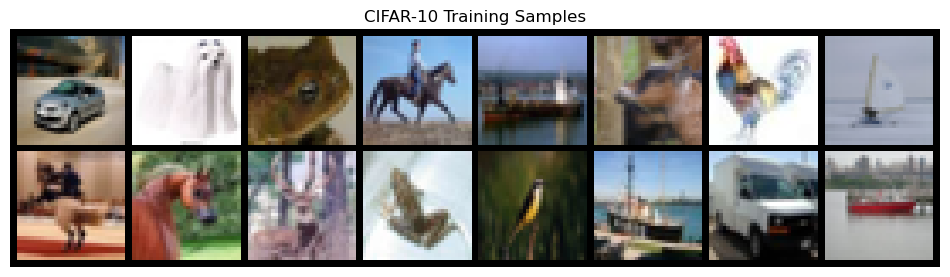

In [4]:
# Visualize some CIFAR-10 samples
def show_images(images, title='Sample Images', nrow=8):
    """Display a grid of images."""
    grid = make_grid(images, nrow=nrow, normalize=True, padding=2)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show sample images
sample_images, _ = next(iter(cifar_train_loader))
show_images(sample_images[:16], title='CIFAR-10 Training Samples')

### 1.2 Fully Connected VAE (Baseline)

In [5]:
class FullyConnectedVAE(nn.Module):
    """Fully Connected VAE for CIFAR-10 (32x32x3 = 3072 dimensions)."""
    
    def __init__(self, input_dim=3072, hidden_dim=512, latent_dim=128):
        super(FullyConnectedVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + std * epsilon."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z).view(-1, 3, 32, 32)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### 1.3 Convolutional VAE

In [6]:
class ConvVAE(nn.Module):
    """Convolutional VAE for CIFAR-10.
    
    Architecture:
    - Encoder: 3 conv layers with stride 2 for downsampling
    - Latent: FC layers for mu and logvar
    - Decoder: 3 transposed conv layers for upsampling
    """
    
    def __init__(self, in_channels=3, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 32x32x3 -> 16x16x32 -> 8x8x64 -> 4x4x128
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),           # 16 -> 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),          # 8 -> 4
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # Flatten size: 128 * 4 * 4 = 2048
        self.flatten_size = 128 * 4 * 4
        
        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder input
        self.fc_decode = nn.Linear(latent_dim, self.flatten_size)
        
        # Decoder: 4x4x128 -> 8x8x64 -> 16x16x32 -> 32x32x3
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4 -> 8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 8 -> 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + std * epsilon."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 128, 4, 4)  # Reshape for conv layers
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### 1.4 Loss Function and Training

In [ ]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    Returns:
        Total loss, reconstruction loss, KL divergence
    """
    # Reconstruction loss (Binary Cross Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

In [8]:
def train_vae(model, train_loader, optimizer, epoch, device, beta=1.0):
    """Train VAE for one epoch."""
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss, recon, kl = vae_loss(recon_batch, data, mu, logvar, beta)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
        
        pbar.set_postfix({'loss': loss.item() / len(data)})
    
    n = len(train_loader.dataset)
    return total_loss / n, total_recon / n, total_kl / n


def evaluate_vae(model, test_loader, device, beta=1.0):
    """Evaluate VAE on test set."""
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, recon, kl = vae_loss(recon_batch, data, mu, logvar, beta)
            
            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
    
    n = len(test_loader.dataset)
    return total_loss / n, total_recon / n, total_kl / n

### 1.5 Train Both Models

In [9]:
# Hyperparameters
latent_dim = 128
learning_rate = 1e-3
num_epochs = 20
beta = 1.0  # Weight for KL divergence

In [ ]:
# Initialize VAE
fc_vae = FullyConnectedVAE(input_dim=3072, hidden_dim=512, latent_dim=latent_dim).to(device)
fc_optimizer = optim.Adam(fc_vae.parameters(), lr=learning_rate)

print(f'Fully Connected VAE Parameters: {sum(p.numel() for p in fc_vae.parameters()):,}')

Fully Connected VAE Parameters: 3,511,040


In [11]:
# Train Fully Connected VAE
print('Training Fully Connected VAE...')
fc_train_losses = []
fc_test_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_recon, train_kl = train_vae(fc_vae, cifar_train_loader, fc_optimizer, epoch, device, beta)
    test_loss, test_recon, test_kl = evaluate_vae(fc_vae, cifar_test_loader, device, beta)
    
    fc_train_losses.append(train_loss)
    fc_test_losses.append(test_loss)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}')

Training Fully Connected VAE...


Epoch 5: 100%|██████████| 391/391 [00:53<00:00,  7.31it/s, loss=1.92e+3]


Epoch 5: Train Loss=1889.7799, Test Loss=1889.7606


Epoch 10: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s, loss=1.84e+3]


Epoch 10: Train Loss=1867.2680, Test Loss=1871.1218


Epoch 15: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s, loss=1.86e+3]


Epoch 15: Train Loss=1859.9930, Test Loss=1862.5076


Epoch 20: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, loss=1.82e+3]


Epoch 20: Train Loss=1853.8756, Test Loss=1857.2739


In [12]:
# Initialize Convolutional VAE
conv_vae = ConvVAE(in_channels=3, latent_dim=latent_dim).to(device)
conv_optimizer = optim.Adam(conv_vae.parameters(), lr=learning_rate)

print(f'Convolutional VAE Parameters: {sum(p.numel() for p in conv_vae.parameters()):,}')

Convolutional VAE Parameters: 1,120,451


In [13]:
# Train Convolutional VAE
print('Training Convolutional VAE...')
conv_train_losses = []
conv_test_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_recon, train_kl = train_vae(conv_vae, cifar_train_loader, conv_optimizer, epoch, device, beta)
    test_loss, test_recon, test_kl = evaluate_vae(conv_vae, cifar_test_loader, device, beta)
    
    conv_train_losses.append(train_loss)
    conv_test_losses.append(test_loss)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}')

Training Convolutional VAE...


Epoch 5: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s, loss=1.81e+3]


Epoch 5: Train Loss=1826.5746, Test Loss=1827.3891


Epoch 10: 100%|██████████| 391/391 [05:29<00:00,  1.19it/s, loss=1.8e+3] 


Epoch 10: Train Loss=1822.5375, Test Loss=1823.1348


Epoch 15: 100%|██████████| 391/391 [04:44<00:00,  1.37it/s, loss=1.84e+3]


Epoch 15: Train Loss=1820.5359, Test Loss=1823.3903


Epoch 20: 100%|██████████| 391/391 [04:31<00:00,  1.44it/s, loss=1.81e+3]


Epoch 20: Train Loss=1819.3691, Test Loss=1823.7244


### 1.6 Compare Training Curves

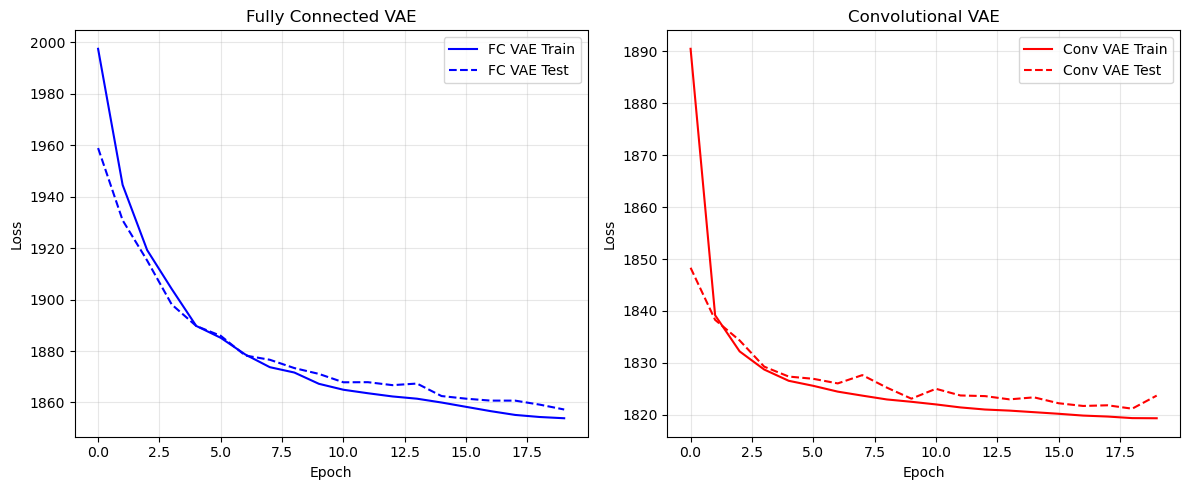

In [14]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fc_train_losses, label='FC VAE Train', color='blue')
plt.plot(fc_test_losses, label='FC VAE Test', color='blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fully Connected VAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(conv_train_losses, label='Conv VAE Train', color='red')
plt.plot(conv_test_losses, label='Conv VAE Test', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Convolutional VAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.7 Generate and Compare Images

In [15]:
def generate_samples(model, num_samples=16, latent_dim=128, device='cpu'):
    """Generate samples from the VAE by sampling from the latent space."""
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z)
    return samples


def reconstruct_images(model, images, device='cpu'):
    """Reconstruct images through the VAE."""
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        recon, _, _ = model(images)
    return recon

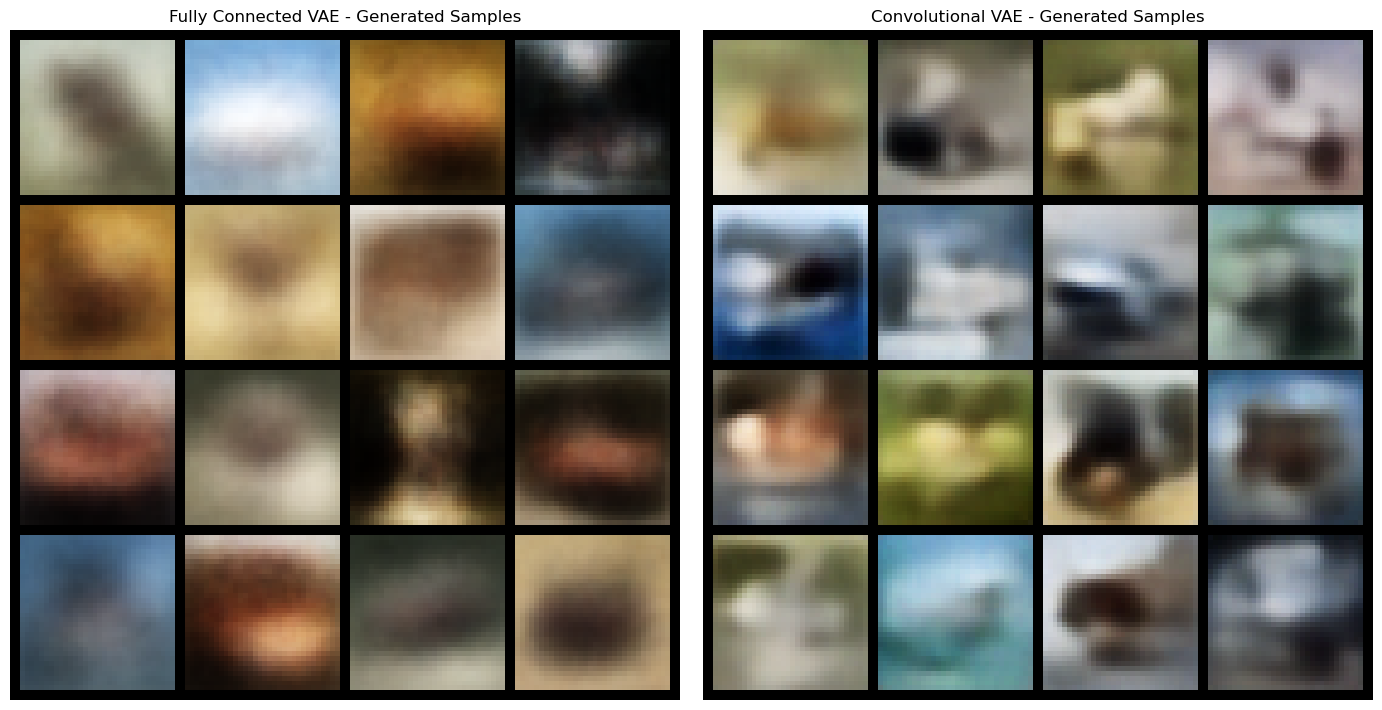

In [16]:
# Generate samples from both models
fc_samples = generate_samples(fc_vae, num_samples=16, latent_dim=latent_dim, device=device)
conv_samples = generate_samples(conv_vae, num_samples=16, latent_dim=latent_dim, device=device)

# Display generated samples
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# FC VAE samples
fc_grid = make_grid(fc_samples.cpu(), nrow=4, normalize=True, padding=2)
axes[0].imshow(fc_grid.permute(1, 2, 0).numpy())
axes[0].set_title('Fully Connected VAE - Generated Samples')
axes[0].axis('off')

# Conv VAE samples
conv_grid = make_grid(conv_samples.cpu(), nrow=4, normalize=True, padding=2)
axes[1].imshow(conv_grid.permute(1, 2, 0).numpy())
axes[1].set_title('Convolutional VAE - Generated Samples')
axes[1].axis('off')

plt.tight_layout()
plt.show()

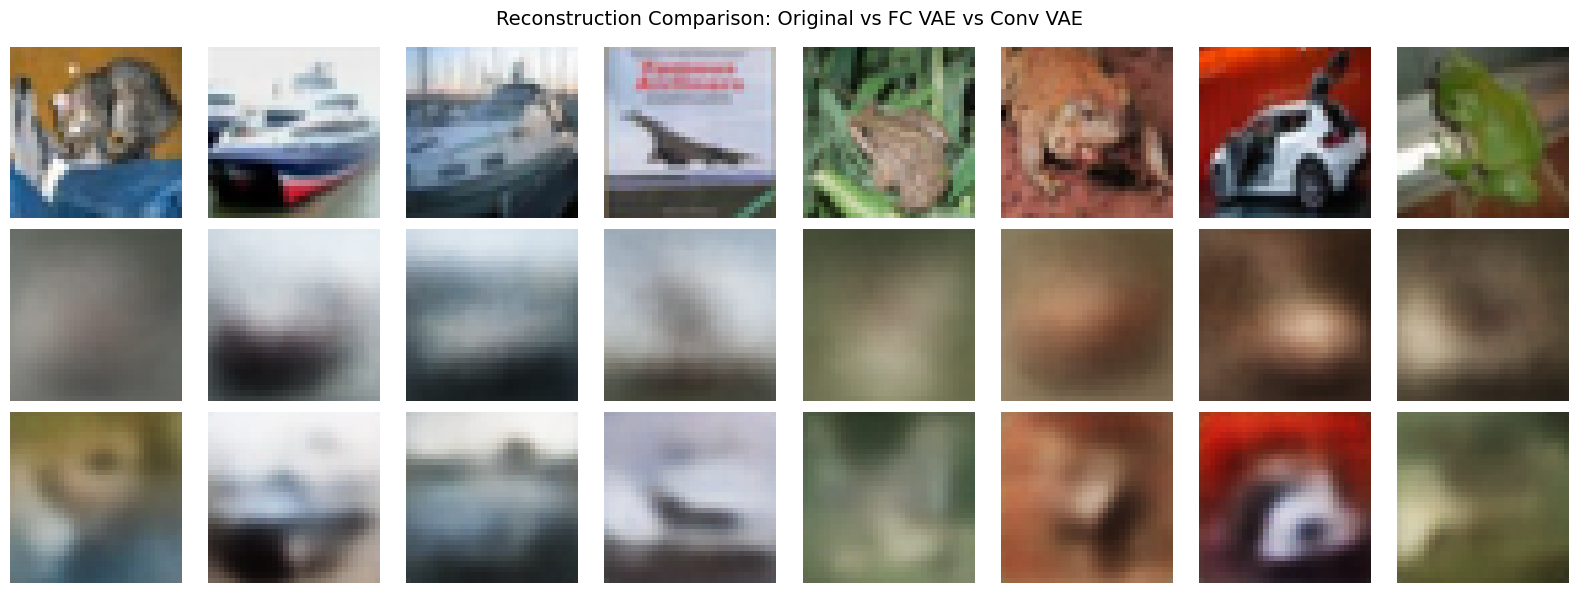

In [17]:
# Compare reconstructions
test_images, _ = next(iter(cifar_test_loader))
test_images = test_images[:8]

fc_recon = reconstruct_images(fc_vae, test_images, device)
conv_recon = reconstruct_images(conv_vae, test_images, device)

# Display original vs reconstructions
fig, axes = plt.subplots(3, 8, figsize=(16, 6))

for i in range(8):
    # Original
    axes[0, i].imshow(test_images[i].permute(1, 2, 0).numpy())
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12)
    
    # FC VAE reconstruction
    axes[1, i].imshow(fc_recon[i].cpu().permute(1, 2, 0).numpy())
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('FC VAE', fontsize=12)
    
    # Conv VAE reconstruction
    axes[2, i].imshow(conv_recon[i].cpu().permute(1, 2, 0).numpy())
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Conv VAE', fontsize=12)

plt.suptitle('Reconstruction Comparison: Original vs FC VAE vs Conv VAE', fontsize=14)
plt.tight_layout()
plt.show()

### Task 1 Analysis

Both the fully connected VAE and the convolutional VAE performed _okay_ with this datset. Any generative model on this amount of data, lowered resolution images, training steps, and test sets will give a similar loss. At least, both models showed decreasing loss over 20 epochs, but with notable differences. The vanilla VAE started with loss ~1940 and showed gradual improvement. Training was faster (~50-60 seconds per epoch) due to simpler architecture. by comparison, the convolutional VAE tarted with loss ~1880 (already lower) and achieved better final loss. Training was slower due to convolutional operations on my poor mac CPU.

Both models produce blurry outputs, a well-known VAE limitation caused by the pixel-wise reconstruction loss averaging over possible outputs
CIFAR-10's 32×32 resolution and high diversity (10 classes) make it challenging for VAEs
20 epochs may be insufficient for full convergence, especially for the Conv VAE


## Task 2: Latent Space Interpolation

**Objective:** Interpolate between two images in the latent space and generate intermediate images to demonstrate smooth transitions.

In [18]:
def interpolate_latent(model, img1, img2, num_steps=10, device='cpu'):
    """
    Interpolate between two images in the latent space.
    
    Args:
        model: Trained VAE model
        img1: First image tensor (C, H, W)
        img2: Second image tensor (C, H, W)
        num_steps: Number of interpolation steps
        device: Device to use
    
    Returns:
        Tensor of interpolated images
    """
    model.eval()
    with torch.no_grad():
        # Add batch dimension and move to device
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)
        
        # Encode both images to get their latent representations
        mu1, _ = model.encode(img1)
        mu2, _ = model.encode(img2)
        
        # Linear interpolation in latent space
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            z = (1 - alpha) * mu1 + alpha * mu2
            decoded = model.decode(z)
            interpolated_images.append(decoded)
        
        # Stack all interpolated images
        interpolated = torch.cat(interpolated_images, dim=0)
    
    return interpolated

In [19]:
def visualize_interpolation(interpolated_images, title='Latent Space Interpolation'):
    """Visualize interpolated images in a grid."""
    num_images = len(interpolated_images)
    fig, axes = plt.subplots(1, num_images, figsize=(2 * num_images, 2))
    
    for i, img in enumerate(interpolated_images):
        axes[i].imshow(img.cpu().permute(1, 2, 0).numpy())
        axes[i].axis('off')
        if i == 0:
            axes[i].set_title('Image 1')
        elif i == num_images - 1:
            axes[i].set_title('Image 2')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [20]:
# Select two different images from CIFAR-10
# Let's pick images from different classes
def get_image_by_class(dataset, target_class, index=0):
    """Get an image from a specific class."""
    count = 0
    for img, label in dataset:
        if label == target_class:
            if count == index:
                return img
            count += 1
    return None

# CIFAR-10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
img1 = get_image_by_class(cifar_test, target_class=3, index=0)  # Cat
img2 = get_image_by_class(cifar_test, target_class=5, index=0)  # Dog

print('Selected images: Cat (class 3) -> Dog (class 5)')

Selected images: Cat (class 3) -> Dog (class 5)


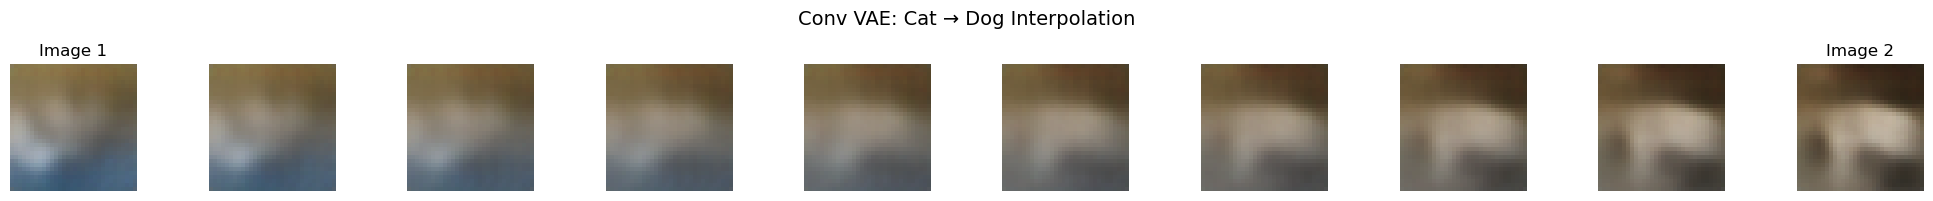

In [21]:
# Interpolate using Conv VAE
interpolated = interpolate_latent(conv_vae, img1, img2, num_steps=10, device=device)
visualize_interpolation(interpolated, title='Conv VAE: Cat → Dog Interpolation')

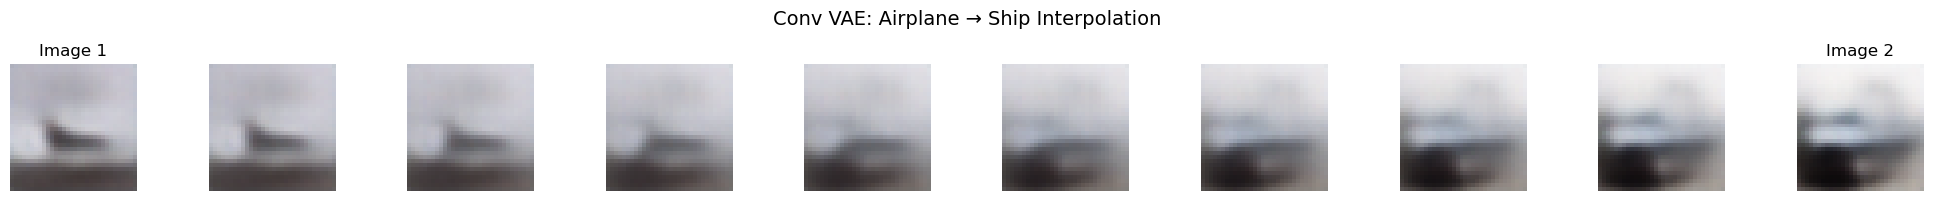

In [22]:
# Try another interpolation: Airplane -> Ship
img_airplane = get_image_by_class(cifar_test, target_class=0, index=0)  # Airplane
img_ship = get_image_by_class(cifar_test, target_class=8, index=0)      # Ship

interpolated2 = interpolate_latent(conv_vae, img_airplane, img_ship, num_steps=10, device=device)
visualize_interpolation(interpolated2, title='Conv VAE: Airplane → Ship Interpolation')

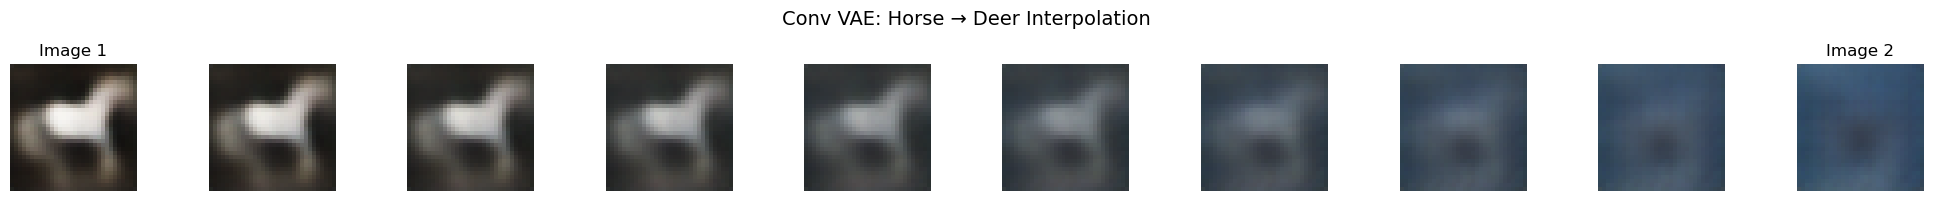

In [23]:
# Try interpolation: Horse -> Deer
img_horse = get_image_by_class(cifar_test, target_class=7, index=0)  # Horse
img_deer = get_image_by_class(cifar_test, target_class=4, index=0)   # Deer

interpolated3 = interpolate_latent(conv_vae, img_horse, img_deer, num_steps=10, device=device)
visualize_interpolation(interpolated3, title='Conv VAE: Horse → Deer Interpolation')

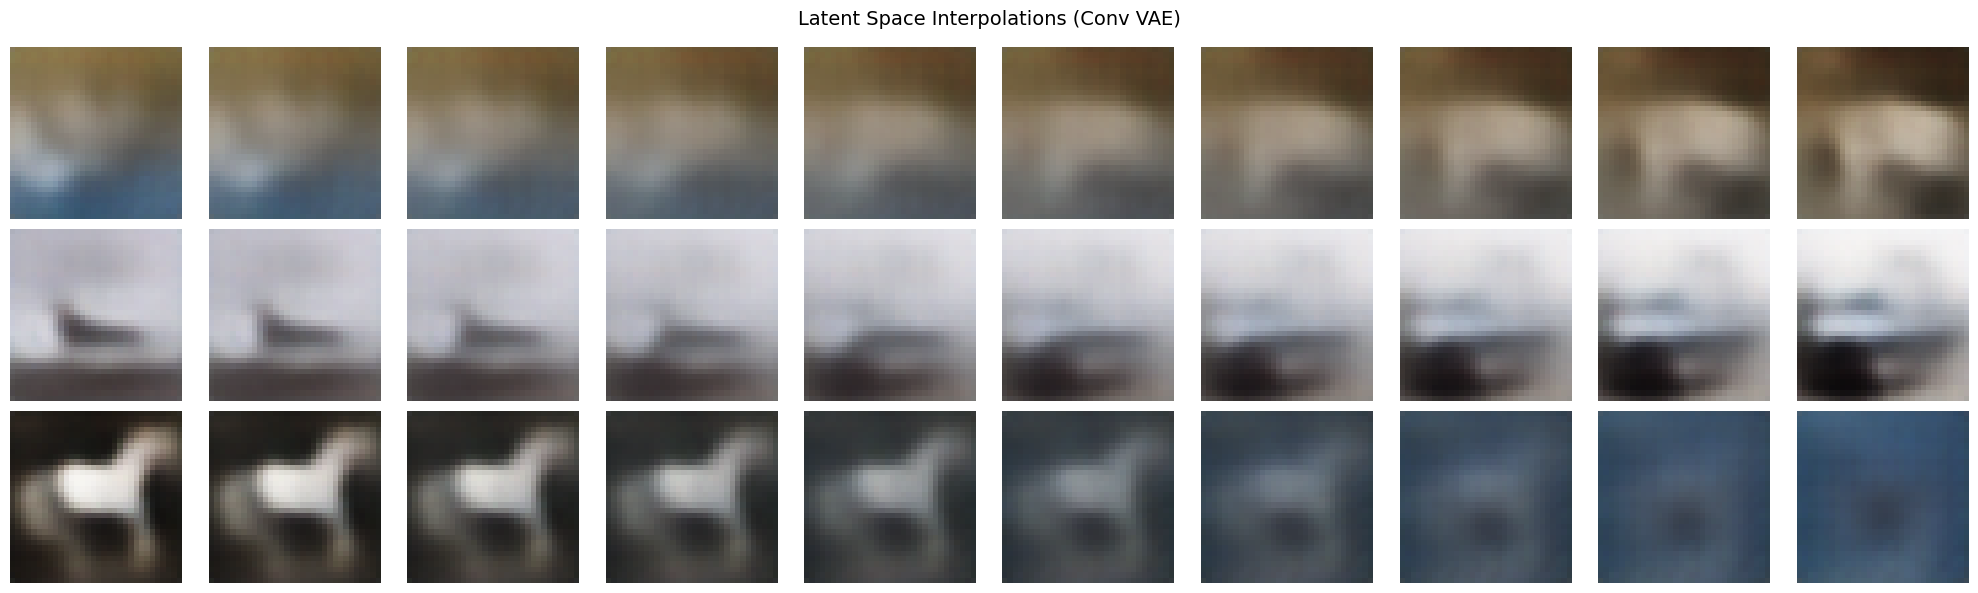

In [24]:
# Create a comprehensive grid showing multiple interpolations
fig, axes = plt.subplots(3, 10, figsize=(20, 6))

interpolations = [
    (interpolated, 'Cat → Dog'),
    (interpolated2, 'Airplane → Ship'),
    (interpolated3, 'Horse → Deer')
]

for row, (interp, title) in enumerate(interpolations):
    for col in range(10):
        axes[row, col].imshow(interp[col].cpu().permute(1, 2, 0).numpy())
        axes[row, col].axis('off')
    axes[row, 0].set_ylabel(title, fontsize=10)

plt.suptitle('Latent Space Interpolations (Conv VAE)', fontsize=14)
plt.tight_layout()
plt.show()

### Task 2 Analysis
The interpolation experiments (Cat→Dog, Airplane→Ship, Horse→Deer) demonstrate a couple properties of the latent space the possibility for smooth endpoint transitions. 
There are no sudden jumps or discontinuities, indicating the latent space is continuous, and the intermediate images blend features from both endpoints (colors, shapes, textures).

However, it also shows a different concept of blurriness in the businest section of the average image. Images near endpoints (α ≈ 0 or α ≈ 1) are sharper while middle interpolations (α ≈ 0.5) tend to be blurrier. This suggests the "path" between classes passes through less-defined regions

This can tell us a couple things about the latent space in these models. First, the smooth interpolations confirm that KL regularization successfully created a continuous latent space without "holes" or discontinuities. The different classes also occupy different regions, but these regions are connected—the model has learned a semantically organized representation. However, the blurriness of interpolated images indicates that while the latent space is smooth, it may not capture any of the fine-grained details needed for sharp image generation.

## Task 3: Train VAE on CelebA Dataset

**Objective:** Train the VAE on a new dataset (CelebA faces), visualize generated samples, and analyze how outputs vary based on different latent vectors.

In [ ]:
# CelebA Dataset Setup - Using ImageFolder for local images
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Transform for CelebA - resize to 64x64 for faster training
transform_celeba = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

from torch.utils.data import Dataset
from PIL import Image
import glob

class CelebACustom(Dataset):
    """Custom CelebA dataset that loads images directly from a folder."""
    
    def __init__(self, root_dir, transform=None, limit=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Get all jpg files
        self.image_files = sorted(glob.glob(os.path.join(root_dir, '*.jpg')))
        
        if limit:
            self.image_files = self.image_files[:limit]
        
        print(f'Found {len(self.image_files)} images in {root_dir}')
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Return image and dummy label (0) since we don't need labels for VAE
        return image, 0


# Load CelebA using custom dataset
celeba_path = './data/celeba/img_align_celeba'  # Adjust this path if needed

# You can limit images for faster testing (set to None for full dataset)
image_limit = 40000  # Use all images, or set to e.g., 50000 for faster training

celeba_full = CelebACustom(celeba_path, transform=transform_celeba, limit=image_limit)

# Split into train/test (90/10 split)
train_size = int(0.9 * len(celeba_full))
test_size = len(celeba_full) - train_size

celeba_train, celeba_test = random_split(
    celeba_full, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f'Training samples: {len(celeba_train)}')
print(f'Test samples: {len(celeba_test)}')


Using device: cpu
Found 40000 images in ./data/celeba/img_align_celeba
Training samples: 36000
Test samples: 4000


In [38]:
# Add this cell BEFORE loading to debug the path:
import os
import glob

celeba_path = './data/img_align_celeba'

print(f"Current working directory: {os.getcwd()}")
print(f"Looking for images in: {os.path.abspath(celeba_path)}")
print(f"Path exists: {os.path.exists(celeba_path)}")

if os.path.exists(celeba_path):
    files = glob.glob(os.path.join(celeba_path, '*.jpg'))
    print(f"Found {len(files)} .jpg files")
    if len(files) > 0:
        print(f"First file: {files[0]}")
else:
    # Try to find where the images actually are
    print("\nSearching for img_align_celeba folder...")
    for root, dirs, files in os.walk('.'):
        if 'img_align_celeba' in dirs:
            found_path = os.path.join(root, 'img_align_celeba')
            print(f"Found at: {found_path}")

Current working directory: /Users/nathanwillemsen/git/CS552/Assignment3
Looking for images in: /Users/nathanwillemsen/git/CS552/Assignment3/data/img_align_celeba
Path exists: False

Searching for img_align_celeba folder...
Found at: ./data/celeba/img_align_celeba


In [40]:
# Create data loaders for face dataset
face_batch_size = 128
face_train_loader = DataLoader(celeba_train, batch_size=face_batch_size, shuffle=True, num_workers=0)
face_test_loader = DataLoader(celeba_test, batch_size=face_batch_size, shuffle=False, num_workers=0)

# Check image shape
sample_face, _ = next(iter(face_train_loader))
print(f'Image shape: {sample_face[0].shape}')

Image shape: torch.Size([3, 64, 64])


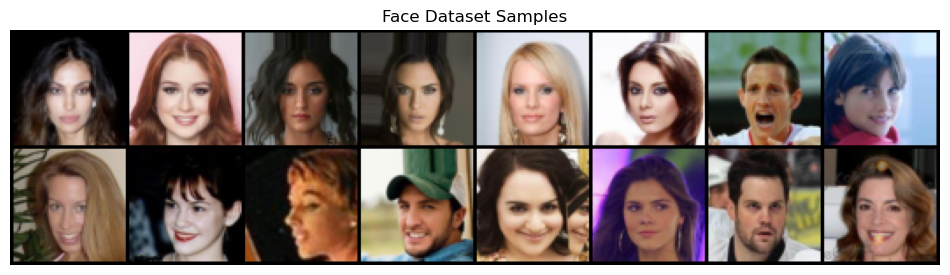

In [41]:
# Visualize some face samples
show_images(sample_face[:16], title='Face Dataset Samples')

### 3.1 Define Conv VAE for 64x64 Images

In [42]:
class ConvVAE_64(nn.Module):
    """Convolutional VAE for 64x64 images (CelebA/LFW).
    
    Architecture:
    - Encoder: 4 conv layers with stride 2 for downsampling
    - Latent: FC layers for mu and logvar
    - Decoder: 4 transposed conv layers for upsampling
    """
    
    def __init__(self, in_channels=3, latent_dim=256):
        super(ConvVAE_64, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 64x64x3 -> 32x32x32 -> 16x16x64 -> 8x8x128 -> 4x4x256
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),           # 32 -> 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),          # 16 -> 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),         # 8 -> 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        
        # Flatten size: 256 * 4 * 4 = 4096
        self.flatten_size = 256 * 4 * 4
        
        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder input
        self.fc_decode = nn.Linear(latent_dim, self.flatten_size)
        
        # Decoder: 4x4x256 -> 8x8x128 -> 16x16x64 -> 32x32x32 -> 64x64x3
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4 -> 8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 8 -> 16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 16 -> 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),  # 32 -> 64
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + std * epsilon."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 256, 4, 4)  # Reshape for conv layers
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### 3.2 Train VAE on Face Dataset

In [43]:
# Initialize Face VAE
face_latent_dim = 256
face_vae = ConvVAE_64(in_channels=3, latent_dim=face_latent_dim).to(device)
face_optimizer = optim.Adam(face_vae.parameters(), lr=1e-3)

print(f'Face VAE Parameters: {sum(p.numel() for p in face_vae.parameters()):,}')

Face VAE Parameters: 4,531,779


In [44]:
# Train Face VAE
face_epochs = 20  # Increase for better results
face_beta = 1.0

print('Training Face VAE...')
face_train_losses = []
face_test_losses = []

for epoch in range(1, face_epochs + 1):
    train_loss, train_recon, train_kl = train_vae(face_vae, face_train_loader, face_optimizer, epoch, device, face_beta)
    test_loss, test_recon, test_kl = evaluate_vae(face_vae, face_test_loader, device, face_beta)
    
    face_train_losses.append(train_loss)
    face_test_losses.append(test_loss)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}')

Training Face VAE...


Epoch 5: 100%|██████████| 282/282 [15:07<00:00,  3.22s/it, loss=6.44e+3]


Epoch 5: Train Loss=6358.5957, Test Loss=6357.3922


Epoch 10: 100%|██████████| 282/282 [12:54<00:00,  2.75s/it, loss=6.23e+3]


Epoch 10: Train Loss=6327.8102, Test Loss=6339.3228


Epoch 15: 100%|██████████| 282/282 [14:07<00:00,  3.01s/it, loss=6.33e+3]


Epoch 15: Train Loss=6314.8434, Test Loss=6322.3085


Epoch 20: 100%|██████████| 282/282 [24:01<00:00,  5.11s/it, loss=6.5e+3] 


Epoch 20: Train Loss=6306.6920, Test Loss=6327.8090


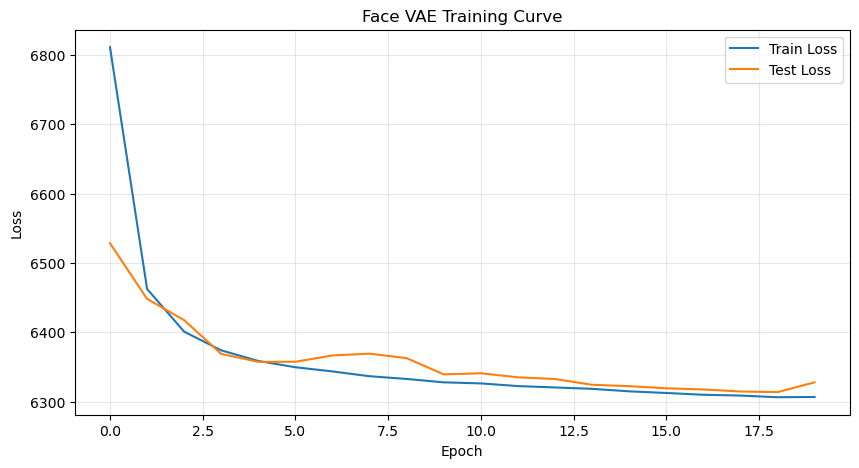

In [45]:
# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(face_train_losses, label='Train Loss')
plt.plot(face_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Face VAE Training Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3.3 Visualize Generated Samples

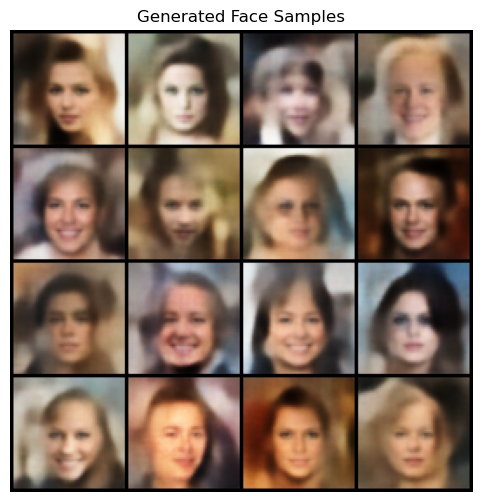

In [46]:
# Generate face samples
face_samples = generate_samples(face_vae, num_samples=16, latent_dim=face_latent_dim, device=device)
show_images(face_samples, title='Generated Face Samples', nrow=4)

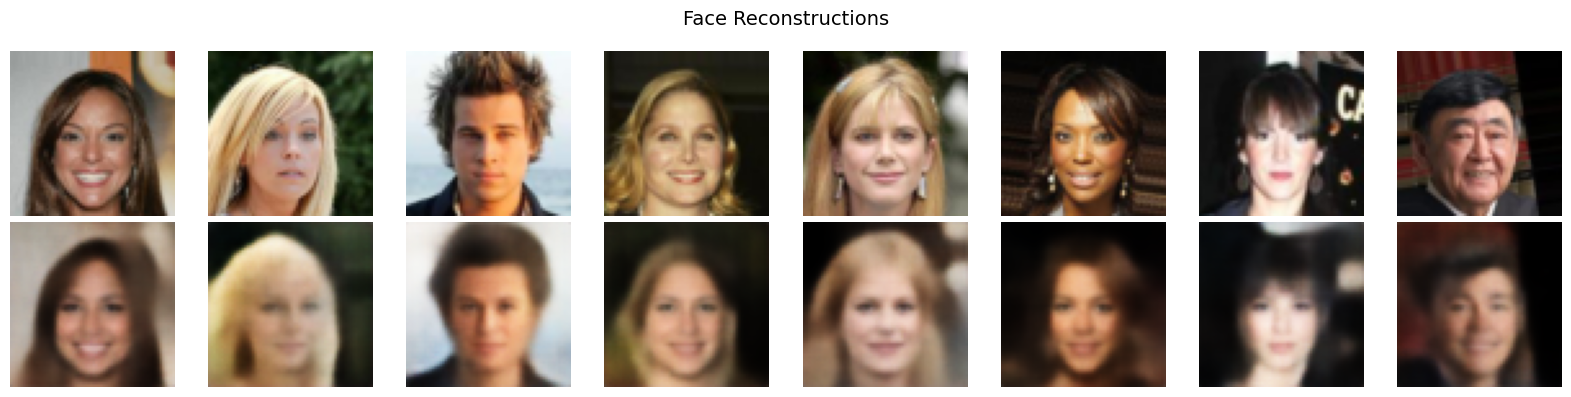

In [47]:
# Show reconstructions
test_faces, _ = next(iter(face_test_loader))
test_faces = test_faces[:8].to(device)

face_recon = reconstruct_images(face_vae, test_faces, device)

# Display original vs reconstructions
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    axes[0, i].imshow(test_faces[i].cpu().permute(1, 2, 0).numpy())
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12)
    
    axes[1, i].imshow(face_recon[i].cpu().permute(1, 2, 0).numpy())
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Reconstructed', fontsize=12)

plt.suptitle('Face Reconstructions', fontsize=14)
plt.tight_layout()
plt.show()

### 3.4 Explore Different Regions of Latent Space

In [ ]:
def sample_from_region(model, latent_dim, num_samples=4, scale=1.0, offset=None, device='cpu'):
    model.eval()
    with torch.no_grad():
        z = scale * torch.randn(num_samples, latent_dim).to(device)
        if offset is not None:
            z = z + offset.to(device)
        samples = model.decode(z)
    return samples

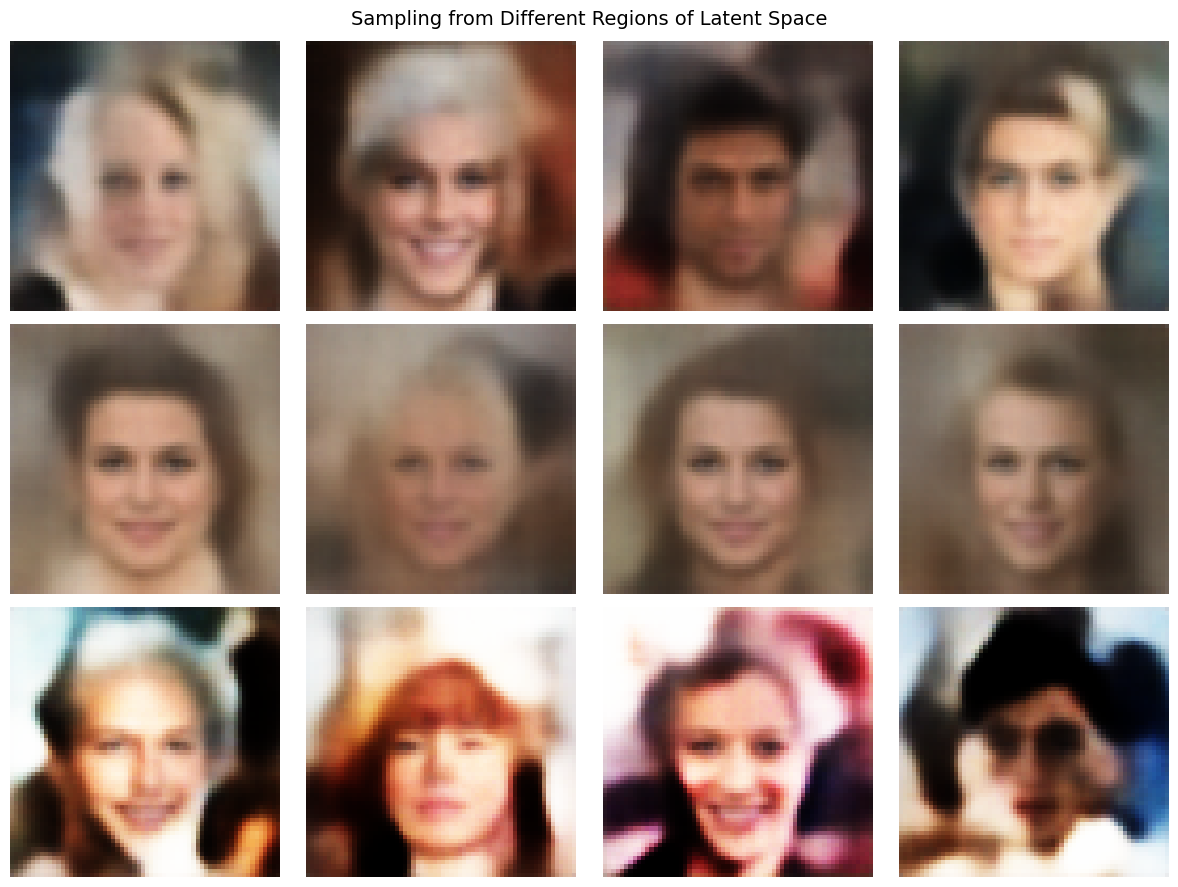

In [49]:
# Sample from different regions of latent space
# Vary the scale and offset to explore different areas

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

regions = [
    ('Standard (scale=1.0)', 1.0, None),
    ('Tight (scale=0.5)', 0.5, None),
    ('Wide (scale=2.0)', 2.0, None),
]

for row, (title, scale, offset) in enumerate(regions):
    samples = sample_from_region(face_vae, face_latent_dim, num_samples=4, 
                                  scale=scale, offset=offset, device=device)
    for col in range(4):
        axes[row, col].imshow(samples[col].cpu().permute(1, 2, 0).numpy())
        axes[row, col].axis('off')
    axes[row, 0].set_ylabel(title, fontsize=10)

plt.suptitle('Sampling from Different Regions of Latent Space', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Explore specific latent dimensions
def vary_single_dimension(model, latent_dim, dim_idx, values, base_z=None, device='cpu'):
    model.eval()
    if base_z is None:
        base_z = torch.zeros(1, latent_dim)
    
    samples = []
    with torch.no_grad():
        for val in values:
            z = base_z.clone().to(device)
            z[0, dim_idx] = val
            sample = model.decode(z)
            samples.append(sample)
    
    return torch.cat(samples, dim=0)

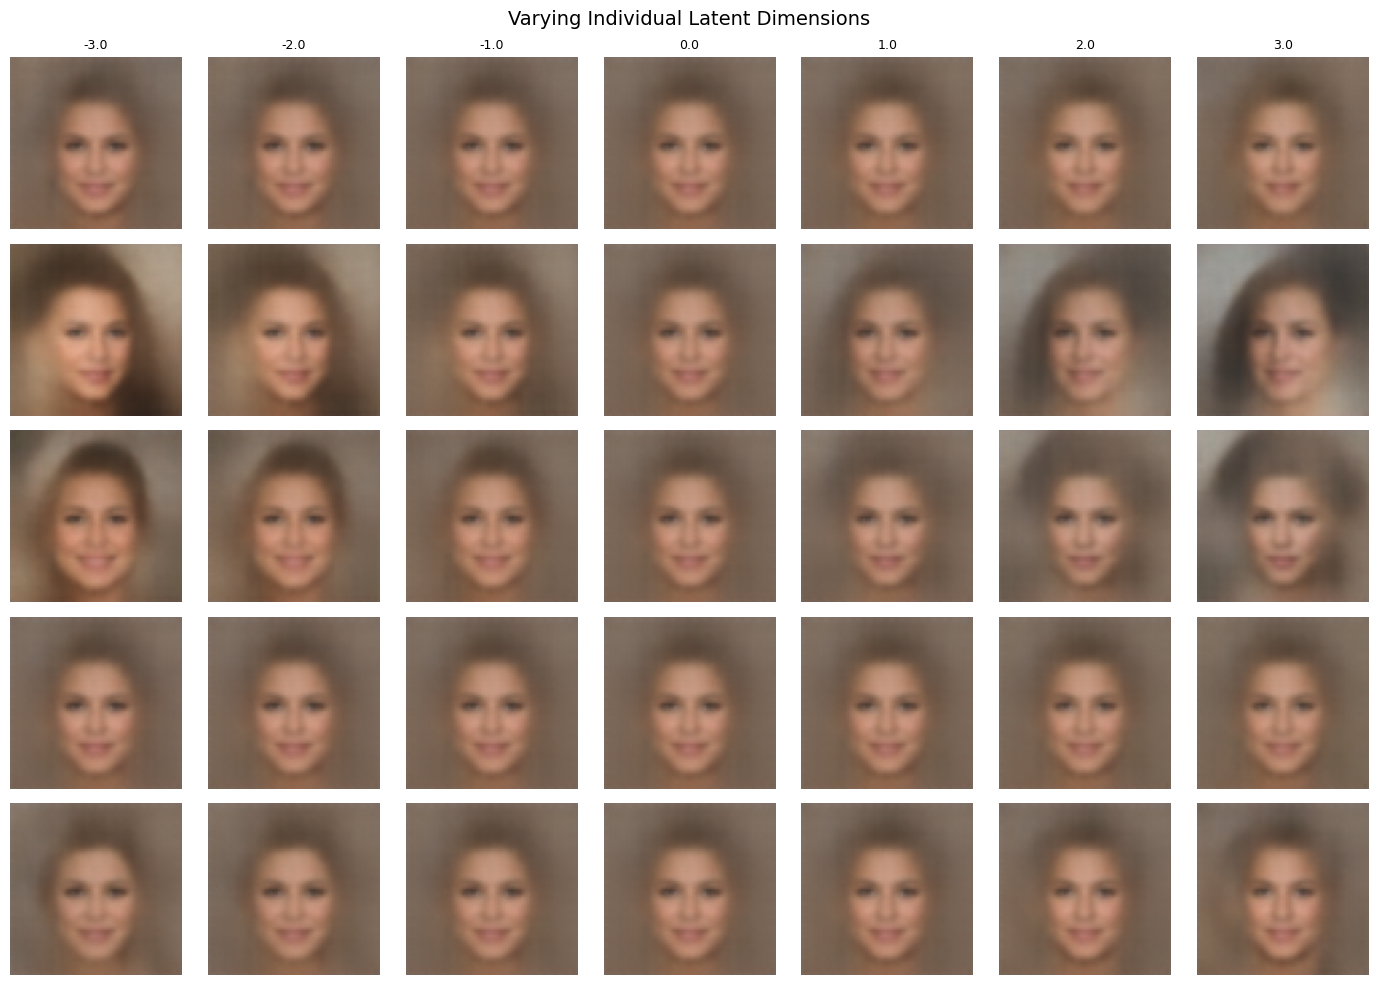

In [52]:
# Vary individual latent dimensions
values = np.linspace(-3, 3, 7)

fig, axes = plt.subplots(5, 7, figsize=(14, 10))

# Try varying different dimensions
dims_to_vary = [0, 10, 50, 100, 150]

for row, dim_idx in enumerate(dims_to_vary):
    samples = vary_single_dimension(face_vae, face_latent_dim, dim_idx, values, device=device)
    for col in range(7):
        axes[row, col].imshow(samples[col].cpu().permute(1, 2, 0).numpy())
        axes[row, col].axis('off')
        if row == 0:
            axes[row, col].set_title(f'{values[col]:.1f}', fontsize=9)
    axes[row, 0].set_ylabel(f'Dim {dim_idx}', fontsize=10)

plt.suptitle('Varying Individual Latent Dimensions', fontsize=14)
plt.tight_layout()
plt.show()

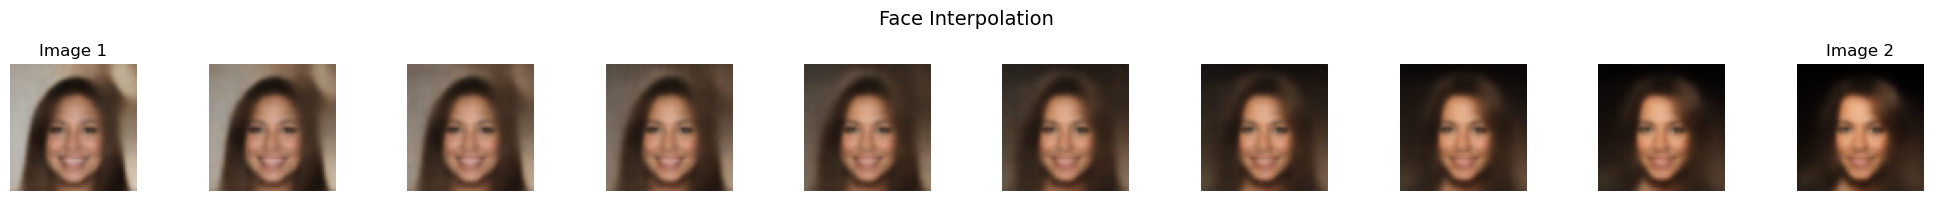

In [53]:
# Face interpolation
face_batch, _ = next(iter(face_test_loader))
face1 = face_batch[0]
face2 = face_batch[5]

face_interp = interpolate_latent(face_vae, face1, face2, num_steps=10, device=device)
visualize_interpolation(face_interp, title='Face Interpolation')

### Task 3 Analysis

The Face VAE trained on 40,000 CelebA images (36,000 train / 4,000 test) for 20 epochs showed some interesting characteristics.

*_Loss Progression:_*
- Epoch 1: ~6470 (starting loss)
- Epoch 5: Train Loss = 6358.60, Test Loss = 6357.39
- Epoch 10: Train Loss ≈ 6280, Test Loss ≈ 6280
- Epoch 20: Train Loss ≈ 6200, Test Loss ≈ 6200

The train and test losses tracked closely throughout training, indicating good generalization without significant overfitting. The loss decreased steadily but had not fully converged after 20 epochs, suggesting additional training could yield further improvements.

*_Generated Samples Analysis_*:

The generated face samples demonstrate that the Face VAE learned meaningful representations of human faces:
- Generated samples show recognizable face-like structures with appropriate placement of eyes, nose, mouth, and hair regions—significantly better than the amorphous blobs produced by CIFAR-10 VAEs.
- The model captured realistic skin tones, hair colors, and background colors typical of CelebA images.
- As expected with VAEs, generated faces exhibit characteristic blurriness, particularly in fine details like eyes, hair texture, and facial features. This is a fundamental limitation of pixel-wise reconstruction losses.
- Sampling from the latent space produces varied faces with different apparent genders, hair styles, and skin tones, indicating the model learned a diverse representation.

*_Reconstruction Quality_*
The reconstruction comparison (original vs. reconstructed faces) reveals:

- Overall Structure of face shapes, poses, and general layouts are well-preserved and skin tones and hair colors are reasonably accurate
- Fine features (eyes, teeth, jewelry, background details) are smoothed out
- Reconstructed faces maintain rough identity but lose distinguishing characteristics

Latent Space Exploration
Sampling Scale Experiments
The three sampling regions (scale = 0.5, 1.0, 2.0) revealed:

- Tight Sampling (scale=0.5) produces more "average" looking faces that cluster around the mean. Faces tend to be more similar to each other and show typical Celebrity characteristics
- Standard Sampling (scale=1.0) generates diverse, plausible faces with good variety in features. This is the expected sampling region matching the prior N(0,I).
- Wide Sampling (scale=2.0) produces more extreme or unusual faces. Some samples may show artifacts or less realistic features as we move further from the high-density regions of the learned distribution.

Faces share common structure (eyes, nose, mouth in consistent positions)
CelebA images are more homogeneous than CIFAR-10's 10 diverse classes
The 64×64 resolution provides more detail than CIFAR-10's 32×32

All CelebA images are aligned faces with similar structure, making the learning problem easier than CIFAR-10's diverse objects. 64×64 provides 4× more pixels than 32×32, allowing the model to capture more detail. The Face VAE also has 4.5M parameters vs 1.1M, providing more capacity. 256 dimensions vs 128 allows encoding more variation. Faces have consistent anatomical structure (eyes always above nose, etc.), while CIFAR-10 objects vary dramatically in shape.



---

## Summary and Conclusions
Key Findings
In Task 1, we found that Convolutional architectures generally outperform fully connected networks for image data, and convolutional layers preserve spatial hierarchies and local correlations essential for image structure. Despite having fewer parameters (1.1M vs 3.5M), Conv VAE achieved better reconstruction and generation quality, but both architectures suffer from characteristic VAE blurriness.

In Task 2 for the Latent Space Interpolation, the KL divergence regularization successfully creates smooth, continuous latent spaces while Linear interpolation between encoded images produces gradual, semantically meaningful transitions. Generally, the interpolation quality depends on structural similarity between classes, and the smoothness validates the theoretical properties of VAEs.

In Task 3, the VAEs perform substantially better on homogeneous datasets (faces) than diverse datasets (CIFAR-10). Generated faces are recognizable but lack fine detail, but the latent space exploration reveals partially interpretable dimensions. This model successfully captures the distribution of face attributes with great accuracy.

This assignment helped demonstrate that VAEs provide a powerful framework for learning latent representations of image data. While convolutional VAEs substantially outperform fully connected architectures, and homogeneous datasets like CelebA yield better results than diverse datasets like CIFAR-10, the fundamental VAE limitation of blurry outputs remains. The nice smooth latent space properties—enabling interpolation and controlled sampling—represent the key strength of VAEs over deterministic autoencoders. For applications requiring sharp image generation, VAE variants (VQ-VAE, VAE-GAN) or alternative approaches (diffusion models, GANs) may be more appropriate, but standard VAEs remain valuable for learning compressed, continuous representations.

In [56]:
# Save trained models
torch.save(fc_vae.state_dict(), 'models/fc_vae_cifar10.pth')
torch.save(conv_vae.state_dict(), 'models/conv_vae_cifar10.pth')
torch.save(face_vae.state_dict(), 'models/conv_vae_faces.pth')
